In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# import tensorflow
import tensorflow as tf
from tensorflow import keras

# import keras
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.models import load_model
from keras.api._v2.keras import activations
from keras.engine.sequential import Sequential
from tensorflow.keras.layers import LSTM, Dense

# import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# 1. Create Data Set

## 1-1. Google Drive connect and files load

In [ ]:
drive.mount('/content/drive') # 코랩에서 구글 드라이브에 마운트

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_path = '/content/drive/MyDrive/PNUProject/AIProject/data'
file_list = os.listdir(drive_path)
file_list

['ma.csv', 'macd.csv', 'rsi.csv', 'bb.csv', 'historydata_v1.csv']

In [ ]:
df_list = []
for i in range(0,len(file_list),1):
  path = drive_path + '/' + file_list[i]
  data = pd.read_csv(path, encoding='cp949')
  path = ''
  df_list.append(data)

In [ ]:
df_list[4].tail()

,open,high,low,close,volume,candel_date_time
19995,31436000.0,31497000.0,31312000.0,31469000.0,440.991947,2023-02-20 11:00:00
19996,31469000.0,31595000.0,31425000.0,31570000.0,327.507823,2023-02-20 12:00:00
19997,31570000.0,31680000.0,31554000.0,31619000.0,280.676325,2023-02-20 13:00:00
19998,31603000.0,31640000.0,31520000.0,31582000.0,219.422516,2023-02-20 14:00:00
19999,31581000.0,31647000.0,31500000.0,31583000.0,285.113594,2023-02-20 15:00:00


## 1-2. Data Preprocessing

In [ ]:
# 1.보조지표 + 종가 데이터 셋 - cdf
cdf = pd.concat([df_list[4]['candel_date_time'],
                 df_list[4]['close'],
                 df_list[0]['MA_C15H'],
                 df_list[1]['MACD'],
                 df_list[2]['RSI'],
                 df_list[3]['BB+'],
                 df_list[3]['BBC'],
                 df_list[3]['BB-']], axis = 1)
# 2. 가격 데이터셋 - pdf
# Way1
df_list[4] = df_list[4][['candel_date_time','open', 'high', 'low', 'close', 'volume']]
pdf = df_list[4]
# Way2
# pdf = pd.concat([df_list[0]['candel_date_time'],
#                 df_list[0]['open'],
#                 df_list[0]['high'],
#                 df_list[0]['low'],
#                 df_list[0]['close'],
#                 df_list[0]['volume']], axis = 1)

In [ ]:
cdf.tail()

,candel_date_time,close,MA_C15H,MACD,RSI,BB+,BBC,BB-
19995,2023-02-20 11:00:00,31469000.0,31692200,-89300,40.9,32099977.0,31722400.0,31344823.0
19996,2023-02-20 12:00:00,31570000.0,31675000,-85000,45.4,32082488.0,31706800.0,31331112.0
19997,2023-02-20 13:00:00,31619000.0,31661200,-76800,47.5,32069830.0,31696450.0,31323070.0
19998,2023-02-20 14:00:00,31582000.0,31641466,-72400,46.1,32063785.0,31688050.0,31312315.0
19999,2023-02-20 15:00:00,31583000.0,31610266,-68100,46.1,32052704.0,31677550.0,31302396.0


In [ ]:
# normalizing data
c_f_scaler = MinMaxScaler()
c_l_scaler = MinMaxScaler()
p_f_scaler = MinMaxScaler()
p_l_scaler = MinMaxScaler()

# normalizing columns setting
c_f_scale_cols = ['MA_C15H', 'MACD', 'RSI', 'BB+', 'BBC','BB-']
c_l_scale_cols = ['close']
p_f_scale_cols = ['open', 'high', 'low', 'volume']
p_l_scale_cols = ['close']

# normalizing used MinMaxScaler
c_f_scaled = c_f_scaler.fit_transform(cdf[c_f_scale_cols])
c_l_scaled = c_l_scaler.fit_transform(cdf[c_l_scale_cols])
p_f_scaled = p_f_scaler.fit_transform(pdf[p_f_scale_cols])
p_l_scaled = p_l_scaler.fit_transform(cdf[p_l_scale_cols])

# Transform to DataFrame
fcdf = pd.DataFrame(c_f_scaled, columns=c_f_scale_cols)
lcdf = pd.DataFrame(c_l_scaled, columns=c_l_scale_cols)
fpdf = pd.DataFrame(p_f_scaled, columns=p_f_scale_cols)
lpdf = pd.DataFrame(p_l_scaled, columns=p_l_scale_cols)

In [ ]:
# define feature and label cols
c_feature_cols = ['MA_C15H', 'MACD', 'RSI', 'BB+', 'BBC','BB-']
c_label_col = ['close']
p_feature_cols = ['open', 'high', 'low', 'volume']
p_label_col = ['close']

# make feature and label DataFrame
c_feature_df = pd.DataFrame(fcdf, columns=c_feature_cols)
p_feature_df = pd.DataFrame(fpdf, columns=p_feature_cols)
c_label_df = pd.DataFrame(lcdf, columns=c_label_col)
p_label_df = pd.DataFrame(lpdf, columns=p_label_col)

# Transform feature and label to numpy
c_feature_np = c_feature_df.to_numpy()
p_feature_np = p_feature_df.to_numpy()
c_label_np = c_label_df.to_numpy()
p_label_np = p_label_df.to_numpy()

## 1-3. Make Sequene Dataset

In [ ]:
def make_sequene_dataset(feature, label, window_size=250):
  feature_list = []
  label_list = []
  for i in range(len(feature)-window_size):
    feature_list.append(feature[i:i+window_size])
    label_list.append(label[i+window_size])
  return np.array(feature_list), np.array(label_list)

In [ ]:
cX, cY = make_sequene_dataset(c_feature_np,c_label_np,250)
print(cX.shape, cY.shape,'\n')
pX, pY = make_sequene_dataset(p_feature_np,p_label_np,250)
print(pX.shape, pY.shape,'\n')

(19750, 250, 6) (19750, 1) 

(19750, 250, 4) (19750, 1) 



# 2. Make Model

## 2-1. Train and Test Data Separation

In [ ]:
split = - 250
cx_train = cX[0:split]
cy_train = cY[0:split]
cx_test = cX[split:]
cy_test = cY[split:]
print(cx_train.shape, cy_train.shape)
print(cx_test.shape, cy_test.shape,'\n')
px_train = pX[0:split]
py_train = pY[0:split]
px_test = pX[split:]
py_test = pY[split:]
print(px_train.shape, py_train.shape)
print(px_test.shape, py_test.shape,'\n')

(19500, 250, 6) (19500, 1)
(250, 250, 6) (250, 1) 

(19500, 250, 4) (19500, 1)
(250, 250, 4) (250, 1) 



## 2-2. Build Up Model

In [ ]:
# Build up C-Model
c_model = Sequential()
c_model.add(LSTM(128,activation='tanh',input_shape=cx_train[0].shape))
c_model.add(Dense(1, activation='linear'))
c_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69120     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Build up P-Model
p_model = Sequential()
p_model.add(LSTM(128,activation='tanh',input_shape=px_train[0].shape))
p_model.add(Dense(1, activation='linear'))
p_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               68096     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Build up CR-Model
cr_model = Sequential()
cr_model.add(LSTM(128,activation='relu',input_shape=cx_train[0].shape))
cr_model.add(Dense(1, activation='linear'))
cr_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               69120     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Build up PR-Model
pr_model = Sequential()
pr_model.add(LSTM(128,activation='relu',input_shape=px_train[0].shape))
pr_model.add(Dense(1, activation='linear'))
pr_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               68096     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


## 2-3. Training Model

### 2-3-1. C-Model

In [ ]:
c_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
c_model.fit(cx_train, cy_train, validation_data=(cx_test, cy_test), epochs=50, batch_size=64, callbacks=[early_stop])

### 2-3-2. CR-Model

In [52]:
cr_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
cr_model.fit(cx_train, cy_train, validation_data=(cx_test, cy_test), epochs=50, batch_size=64, callbacks=[early_stop])

Epoch 1/50
305/305 [==============================] - 157s 507ms/step - loss: 0.0041 - mae: 0.0199 - val_loss: 3.1347e-05 - val_mae: 0.0044
Epoch 2/50
305/305 [==============================] - 155s 507ms/step - loss: 6.6347e-05 - mae: 0.0054 - val_loss: 1.6695e-05 - val_mae: 0.0033
Epoch 3/50
305/305 [==============================] - 157s 516ms/step - loss: 5.7738e-05 - mae: 0.0050 - val_loss: 1.2896e-05 - val_mae: 0.0023
Epoch 4/50
305/305 [==============================] - 153s 503ms/step - loss: 5.6738e-05 - mae: 0.0051 - val_loss: 1.1387e-05 - val_mae: 0.0022
Epoch 5/50
305/305 [==============================] - 160s 524ms/step - loss: 5.3093e-05 - mae: 0.0049 - val_loss: 1.3913e-05 - val_mae: 0.0024
Epoch 6/50
305/305 [==============================] - 173s 568ms/step - loss: 5.0738e-05 - mae: 0.0049 - val_loss: 1.1870e-05 - val_mae: 0.0024
Epoch 7/50
305/305 [==============================] - 172s 562ms/step - loss: 4.6098e-05 - mae: 0.0046 - val_loss: 1.2721e-05 - val_mae: 0.0

### 2-3-2. P-Model

In [ ]:
p_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
p_model.fit(px_train, py_train, validation_data=(px_test, py_test), epochs=50, batch_size=64, callbacks=[early_stop])

Epoch 1/50
305/305 [==============================] - 164s 528ms/step - loss: 0.0020 - mae: 0.0151 - val_loss: 2.2534e-05 - val_mae: 0.0028
Epoch 2/50
305/305 [==============================] - 161s 529ms/step - loss: 8.3801e-05 - mae: 0.0058 - val_loss: 2.2725e-05 - val_mae: 0.0028
Epoch 3/50
305/305 [==============================] - 153s 501ms/step - loss: 8.1570e-05 - mae: 0.0058 - val_loss: 2.1144e-05 - val_mae: 0.0031
Epoch 4/50
305/305 [==============================] - 156s 512ms/step - loss: 7.8654e-05 - mae: 0.0057 - val_loss: 2.3199e-05 - val_mae: 0.0032
Epoch 5/50
305/305 [==============================] - 162s 532ms/step - loss: 7.4998e-05 - mae: 0.0055 - val_loss: 2.1384e-05 - val_mae: 0.0034
Epoch 6/50
305/305 [==============================] - 160s 523ms/step - loss: 7.4489e-05 - mae: 0.0056 - val_loss: 2.1070e-05 - val_mae: 0.0029
Epoch 7/50
305/305 [==============================] - 164s 539ms/step - loss: 7.0009e-05 - mae: 0.0054 - val_loss: 1.6105e-05 - val_mae: 0.0

## 2-4. Save Model


In [56]:
cr_model.save('cr_model.h5')
#c_model.save('c_model.h5')
#p_model.save('p_model.h5')

# 3. Predic Price

## 3-1. C-model predict price

8/8 [==============================] - 2s 252ms/step


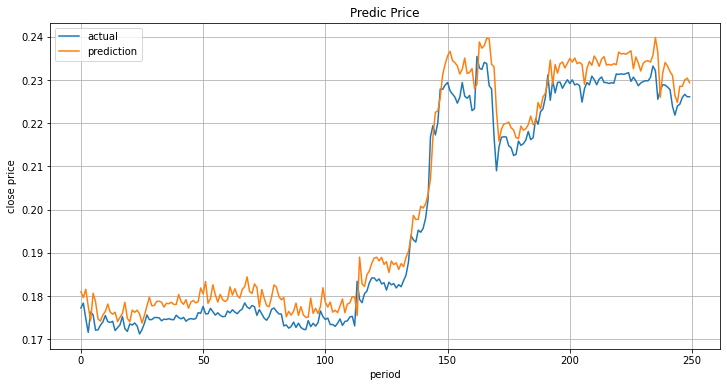

In [36]:
# predic C-Model
c_pred = c_model.predict(cx_test)

plt.figure(figsize=(12, 6))
plt.title('Predic Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(cy_test, label='actual')
plt.plot(c_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

MSE : 98670107248.224 , RMSE : 314117.983


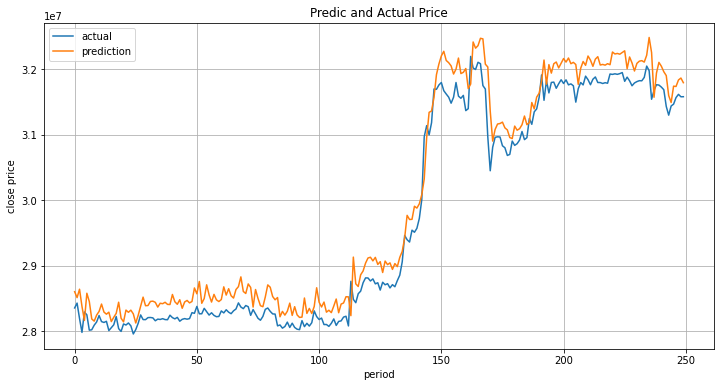

In [46]:
# Revert normalized predic and actual data
rf_c_pred = pd.DataFrame(c_l_scaler.inverse_transform(c_pred),columns=['c_pred_close'])
rf_c_test = pd.DataFrame(c_l_scaler.inverse_transform(cy_test),columns=['actual_close'])

nc_mse = mean_squared_error(rf_c_test, rf_c_pred)
nc_rmse = np.sqrt(nc_mse)

plt.figure(figsize=(12, 6))
plt.title('Predic and Actual Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(rf_c_test, label='actual')
plt.plot(rf_c_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(nc_mse , nc_rmse))
plt.show()

## 3-2. CR-model predict price

8/8 [==============================] - 1s 125ms/step


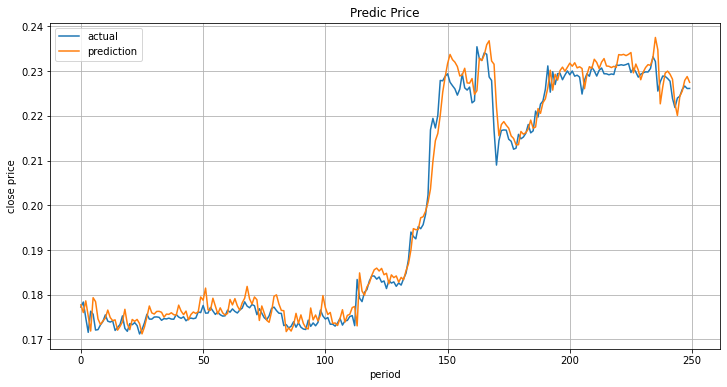

In [53]:
# predic C-Model
cr_pred = cr_model.predict(cx_test)

plt.figure(figsize=(12, 6))
plt.title('Predic Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(cy_test, label='actual')
plt.plot(cr_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

MSE : 41482405480.576 , RMSE : 203672.299


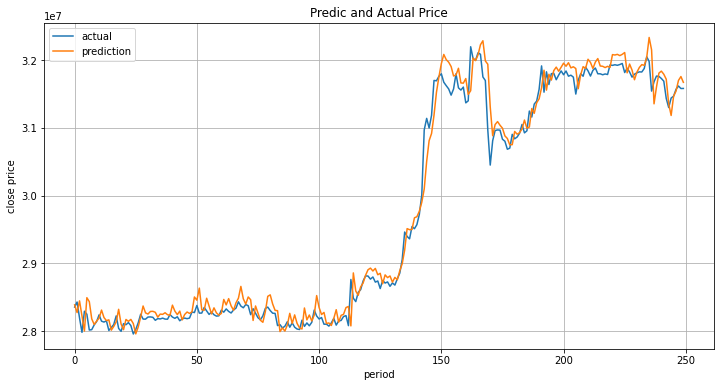

In [55]:
rf_cr_pred = pd.DataFrame(c_l_scaler.inverse_transform(cr_pred),columns=['cr_pred_close'])
rf_cr_test = pd.DataFrame(c_l_scaler.inverse_transform(cy_test),columns=['actual_close'])

ncr_mse = mean_squared_error(rf_cr_test, rf_cr_pred)
ncr_rmse = np.sqrt(ncr_mse)

plt.figure(figsize=(12, 6))
plt.title('Predic and Actual Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(rf_cr_test, label='actual')
plt.plot(rf_cr_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(ncr_mse , ncr_rmse))
plt.show()

## 3-3. P-model predict price

8/8 [==============================] - 1s 128ms/step


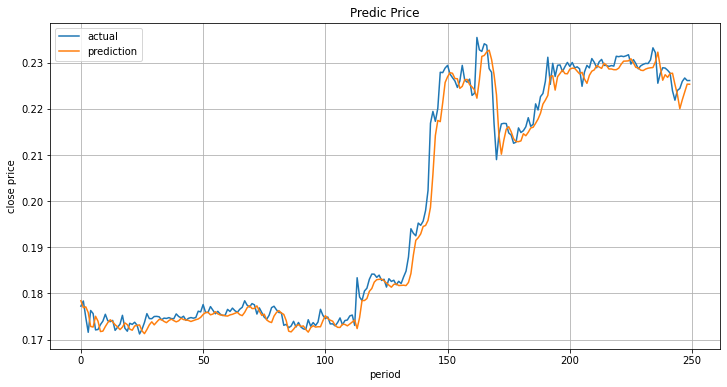

In [38]:
# predic P-Model
p_pred = p_model.predict(px_test)

plt.figure(figsize=(12, 6))
plt.title('Predic Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(py_test, label='actual')
plt.plot(p_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

MSE : 42304581820.768 , RMSE : 205680.776


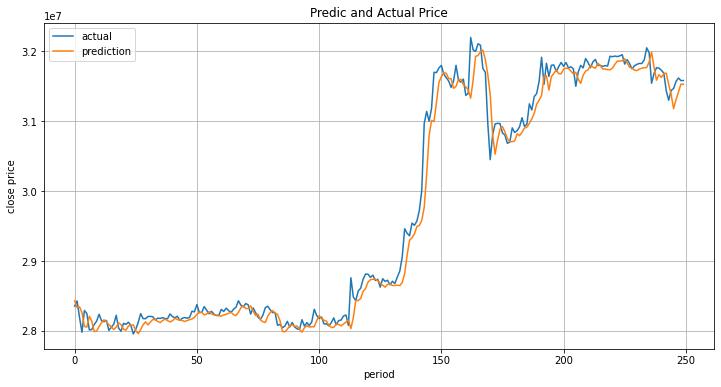

In [44]:
# Revert normalized predic and actual data
rf_p_pred = pd.DataFrame(p_l_scaler.inverse_transform(p_pred),columns=['p_pred_close'])
rf_p_test = pd.DataFrame(p_l_scaler.inverse_transform(py_test),columns=['actual_close'])

np_mse = mean_squared_error(rf_p_test, rf_p_pred)
np_rmse = np.sqrt(np_mse)

plt.figure(figsize=(12, 6))
plt.title('Predic and Actual Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(rf_p_test, label='actual')
plt.plot(rf_p_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(np_mse , np_rmse))
plt.show()

## 3-3. Save Predic Price

In [42]:
rf_p_test.tail()

,actual_close
245,31469000.0
246,31570000.0
247,31619000.0
248,31582000.0
249,31583000.0


In [47]:
date_df = pd.DataFrame(cdf['candel_date_time'][-250:].to_numpy(), columns=['candel_date_time'])
pred_df = pd.concat([date_df['candel_date_time'],rf_p_test['actual_close'],rf_p_pred['p_pred_close'],rf_c_pred['c_pred_close']], axis=1)
pred_df

,candel_date_time,actual_close,p_pred_close,c_pred_close
0,2023-02-10 06:00:00,28354000.0,28431734.0,28602366.0
1,2023-02-10 07:00:00,28428000.0,28332678.0,28511722.0
2,2023-02-10 08:00:00,28193000.0,28344030.0,28640052.0
3,2023-02-10 09:00:00,27980000.0,28262384.0,28378286.0
4,2023-02-10 10:00:00,28292000.0,28063584.0,28162924.0
...,...,...,...,...
245,2023-02-20 11:00:00,31469000.0,31179712.0,31744170.0
246,2023-02-20 12:00:00,31570000.0,31306406.0,31739586.0
247,2023-02-20 13:00:00,31619000.0,31421082.0,31838540.0
248,2023-02-20 14:00:00,31582000.0,31531012.0,31868356.0


In [48]:
pred_df.to_csv('TL_PredictPrice.csv',index=False, encoding='cp949')